# Feature selection for classification -- Random forest
We use Random Forest for our binary classification of Blood Cancer. In particular, we will explore:
1. Variable Importance
1. Pruning (cost complexity)
1. ID3/C4.5 (NOT DONE)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# from imblearn.over_sampling import SMOTE
import itertools
from pprint import pprint

from sklearn.model_selection import train_test_split, cross_val_score, validation_curve, RandomizedSearchCV, cross_validate
from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import confusion_matrix, classification_report, roc_curve, accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, roc_auc_score, roc_curve, f1_score

%matplotlib inline
plt.style.use('seaborn-white')

### 1. Understanding the data

In [2]:
lung_train = pd.read_csv("dataset/lung_training_balanced.csv")
lung_test = pd.read_csv("dataset/lung_test.csv")

In [3]:
lung_train.shape, lung_test.shape

((913, 17395), (205, 17395))

In [4]:
lung_train.columns # has class and label

Index(['A1BG..1.', 'A1CF..29974.', 'A2M..2.', 'A2ML1..144568.',
       'A3GALT2..127550.', 'A4GALT..53947.', 'A4GNT..51146.', 'AAAS..8086.',
       'AACS..65985.', 'AADAC..13.',
       ...
       'ZXDA..7789.', 'ZXDB..158586.', 'ZXDC..79364.', 'ZYG11A..440590.',
       'ZYG11B..79699.', 'ZYX..7791.', 'ZZEF1..23140.', 'ZZZ3..26009.',
       'label', 'class'],
      dtype='object', length=17395)

In [5]:
lung_test.columns # has DepMap_ID and label

Index(['DepMap_ID', 'A1BG..1.', 'A1CF..29974.', 'A2M..2.', 'A2ML1..144568.',
       'A3GALT2..127550.', 'A4GALT..53947.', 'A4GNT..51146.', 'AAAS..8086.',
       'AACS..65985.',
       ...
       'ZWINT..11130.', 'ZXDA..7789.', 'ZXDB..158586.', 'ZXDC..79364.',
       'ZYG11A..440590.', 'ZYG11B..79699.', 'ZYX..7791.', 'ZZEF1..23140.',
       'ZZZ3..26009.', 'label'],
      dtype='object', length=17395)

In [6]:
sum(lung_train.label == 1)/len(lung_train)

# 21% of obs has labelled as lung cancer

0.21029572836801752

In [7]:
sum(lung_train['label'] == lung_train['class']) == len(lung_train)

# OK, label and class are the same, we can drop them

True

In [8]:
X_train = lung_train.drop(['label', 'class'], axis = 1)
y_train = lung_train['label']


X_test = lung_test.drop(['DepMap_ID', 'label'], axis = 1)
y_test = lung_test['label']

### 2. Random Forest classifier

A Random Forest is an *ensemble* method, i.e. an approach that combines many simple methods. here classification trees, to obotain a single and more powerful one. In particular, Random Forests fit different decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy. 
The sub-sample size is controlled with the max_samples parameter if bootstrap=True (default). If max_samples = n_features, then the whole dataset is used to build each tree and this is called Bagging.

___________________
Why not Bagging?

Primarly for two reasons:
1. our dataset is "too big", it is computationally onerous using all variables;
2. tree in bagging can be higly correlated.

___________________
What is *bootstrap*?

Each tree in the Random Forest learns from a random sample which is **drawn with replacement**. Thus, some samples can be used multiple times in a single tree.
In this situation, it can be shown that on average not all observation are used to fit the tree. Then, the idea is to use these remaing observations, known as *out-of-bag* obs, for quickly estimating the generalization accuracy. An oob error estimate is almost identical to that obtained by k-fold cv. Unlike many other nonlinear estimators, random forests can be fit in one sequence, with cross-validation being performed along the way.

___________________
What is *class_weight*?

Weights associated with classes in the form {class_label: weight}. If not given, all classes are supposed to have weight one. 

The *balanced* mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data as n_samples / (n_classes * np.bincount(y))

The *balanced_subsample* mode is the same as balanced except that weights are computed based on the bootstrap sample for every tree grown.

___________________
Why we do not prune Random Forests?

Roughly speaking, some of the potential over-fitting that might happen in a single tree (which is a reason you do pruning generally) is mitigated because:
* bootstrap samples are used to train the individual trees;
* we have a multitude of random trees using random features and thus the individual trees are strong but not so correlated with each other.

In [9]:
rf = RandomForestClassifier(random_state = 2311, n_jobs = -1,
                    min_samples_leaf = 50, n_estimators = 500,
                    max_depth = 40, class_weight = "balanced_subsample",
                    bootstrap = True, oob_score = True)

In [10]:
rf.fit(X_train, y_train)
print('Training score: ', rf.score(X_train, y_train))
print('Test score: ', rf.score(X_test, y_test))

C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Training score:  0.9780941949616648
Test score:  0.8439024390243902


In [12]:
y_pred = rf.predict(X_test)
accuracy_score(y_test, y_pred)
print(f'The accuracy of the model is {round(accuracy_score(y_test, y_pred), 3)*100} %')

print(f'Predicted vs. True: {y_pred.sum(), y_test.sum()}')

# Not so good result: it cannot dedect correctly the minority class

The accuracy of the model is 84.39999999999999 %


(6, 30)

In [16]:
# Confusion matrix
def plot_confusion_matrix(cm, classes, normalize = False,
                          title = 'Confusion matrix',
                          cmap = plt.cm.Oranges):

    plt.figure(figsize = (10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    # Label the plot
    for i, j in itertools.product(range(cm.shape[0]),   range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), 
                fontsize = 20,
                horizontalalignment = "center",
                color = "white" if cm[i, j] > thresh else "black")
        plt.grid(None)
        plt.tight_layout()
        plt.ylabel('True label', size = 18)
        plt.xlabel('Predicted label', size = 18)

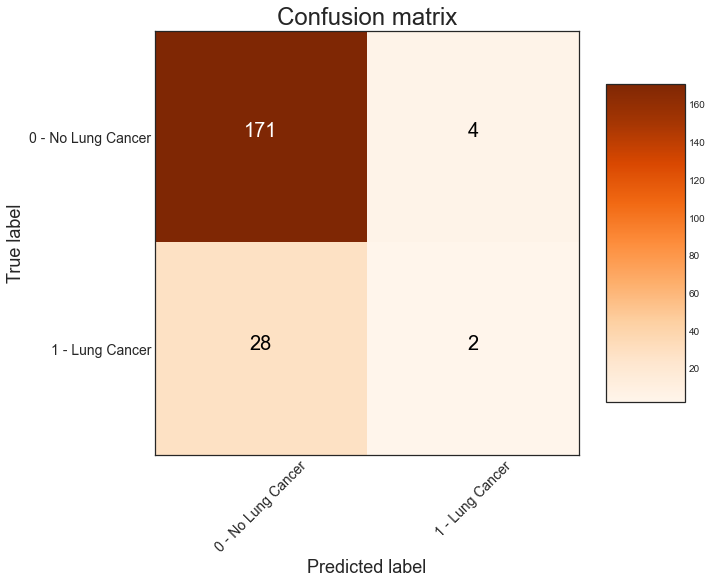

In [17]:
# Let us plot it
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, classes = ['0 - No Lung Cancer', '1 - Lung Cancer'])

In [18]:
# # Feature Importances
# # REM: the Random Forest Library implements the Gini Importance
# feat_impo = rf.feature_importances_

# # Then sort the feature importances by most important first
# feat_impo_ranked = pd.Series(rf.feature_importances_, index = X_train.columns).sort_values(ascending = False)
# feat_impo_ranked = pd.DataFrame({"Gene":feat_impo_ranked.index, "Importance":feat_impo_ranked.values})

# # Print out the first 200 feature and importances
# for gene in range(200):
#     print(f"Gene '{feat_impo_ranked.Gene[gene]}' has Importance: {feat_impo_ranked.Importance[gene]}")

In [19]:
feat_impo = pd.DataFrame(rf.feature_importances_,
                        index = X_train.columns,
                        columns = ['Importance']).sort_values('Importance', ascending = False)

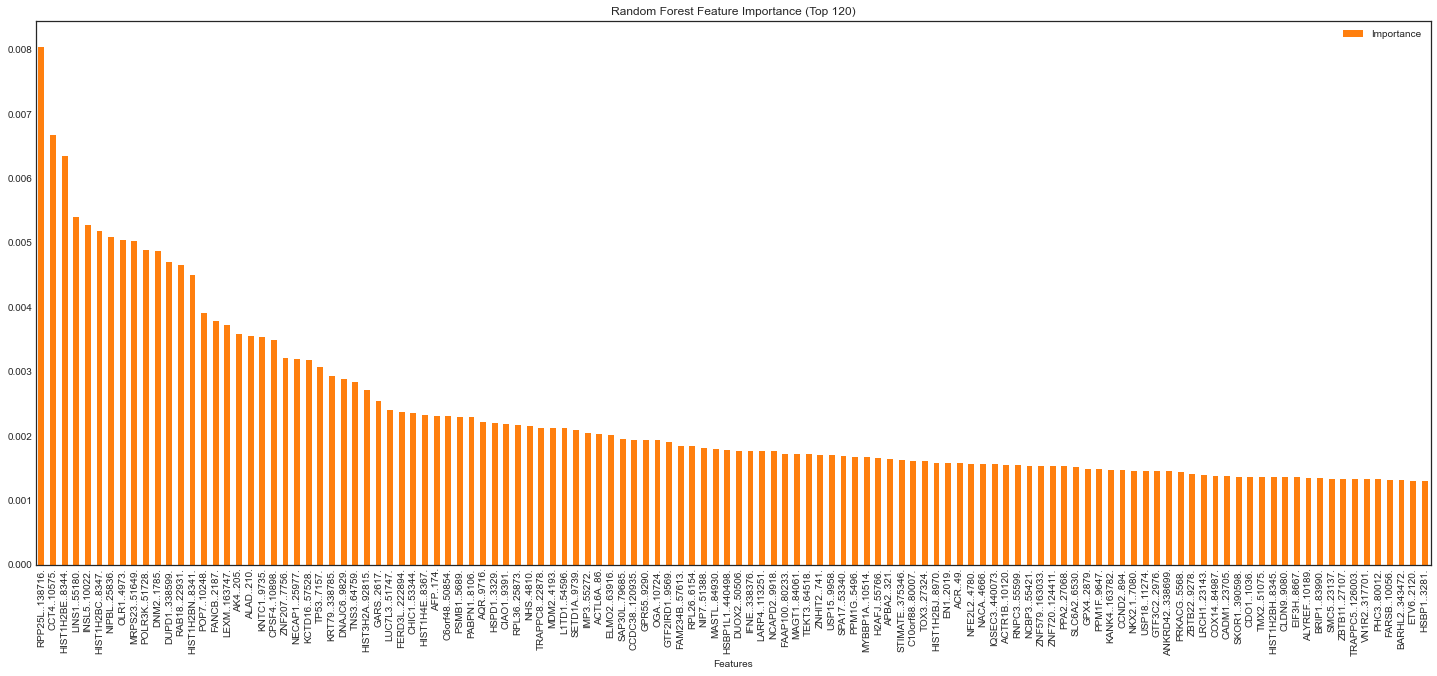

In [20]:
feat_impo[:120].plot.bar(figsize = (25, 10), color = 'tab:orange')
plt.title('Random Forest Feature Importance (Top 120)')
plt.xlabel('Features')
plt.show()

In [21]:
# ROC curve plot

def evaluate_model(y_pred, y_test, probs, y_train, train_predictions, train_probs):
    baseline = {}
    baseline['recall'] = recall_score(y_test, [1 for _ in range(len(y_test))])
    baseline['precision'] = precision_score(y_test, [1 for _ in range(len(y_test))])
    baseline['roc'] = 0.5
    
    results = {}
    results['recall'] = recall_score(y_test, y_pred)
    results['precision'] = precision_score(y_test, y_pred)
    results['roc'] = roc_auc_score(y_test, probs)
    
    train_results = {}
    train_results['recall'] = recall_score(y_train, train_predictions)
    train_results['precision'] = precision_score(y_train, train_predictions)
    train_results['roc'] = roc_auc_score(y_train, train_probs)
    
    for metric in ['recall', 'precision', 'roc']:
        print(f'{metric.capitalize()} Baseline: {round(baseline[metric], 2)} - Test: {round(results[metric], 2)}, Train: {round(train_results[metric], 2)}')

    # Calculate false positive rates and true positive rates
    base_fpr, base_tpr, _ = roc_curve(y_test, [1 for _ in range(len(y_test))])
    model_fpr, model_tpr, _ = roc_curve(y_test, probs)
    plt.figure(figsize = (8, 6))
    plt.rcParams['font.size'] = 16

    # Plot both curves
    plt.plot(base_fpr, base_tpr, 'k--', label = 'Baseline')
    plt.plot(model_fpr, model_tpr, 'tab:orange', label = 'Model')
    plt.legend()
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate'); plt.title('ROC Curves')
    plt.show()

In [22]:
train_predictions = rf.predict(X_train)
train_probs = rf.predict_proba(X_train)[:, 1]
probs = rf.predict_proba(X_test)[:, 1]

print(f'Train ROC AUC Score: {roc_auc_score(y_train, train_probs)}')
print(f'Test ROC AUC Score: {roc_auc_score(y_test, probs)}')

Train ROC AUC Score: 0.9986274849745724
Test ROC AUC Score: 0.7055238095238094


Recall Baseline: 1.0 - Test: 0.07, Train: 0.9
Precision Baseline: 0.15 - Test: 0.33, Train: 1.0
Roc Baseline: 0.5 - Test: 0.71, Train: 1.0


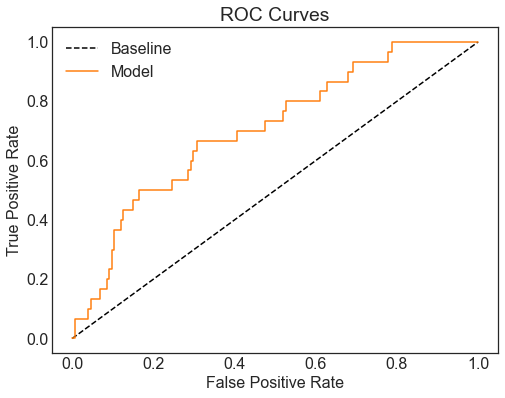

In [23]:
evaluate_model(y_pred, y_test, probs, y_train, train_predictions, train_probs)

This classification is not good. We try a 5-fold cross-validation in order to finding the optimal tuning parameters.

In [25]:
# Our current parameters
print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': 'balanced_subsample',
 'criterion': 'gini',
 'max_depth': 40,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 50,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 500,
 'n_jobs': -1,
 'oob_score': True,
 'random_state': 2311,
 'verbose': 0,
 'warm_start': False}


In [26]:
# 5-Fold Cross validation to validate the model
rf_cl = RandomForestClassifier(oob_score = True)
np.mean(cross_val_score(rf_cl, X_train, y_train, cv = 5))

# 88% cv score

C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py:441: 

0.8795832582717829

Let us use random grid to select the best model, based on the ROC_AUC score, hence scoring = 'roc_auc'.

In [27]:
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 700, num = 50)]
max_features = ['auto', 'log2']  # Number of features to consider at every split
max_depth = [int(x) for x in np.linspace(2, 68, num = 11)]   # Maximum number of levels in tree
max_depth.append(None)
min_samples_split = [2, 5, 10]  # Minimum number of samples required to split a node
min_samples_leaf = [1, 4, 10]    # Minimum number of samples required at each leaf node
bootstrap = [True, False]       # Method of selecting samples for training each tree
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'max_leaf_nodes': [None] + list(np.linspace(10, 50, 200).astype(int)),
               'bootstrap': bootstrap}

rf_random = RandomizedSearchCV(
                estimator = rf_cl,
                param_distributions = random_grid,
                n_iter = 2, cv = 5,
                verbose = 2, random_state = 2311, 
                scoring = 'roc_auc')

In [28]:
# Finally, fit the data
rf_random.fit(X_train, y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[CV] END bootstrap=True, max_depth=48, max_features=auto, max_leaf_nodes=35, min_samples_leaf=4, min_samples_split=10, n_estimators=504; total time= 1.6min


C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[CV] END bootstrap=True, max_depth=48, max_features=auto, max_leaf_nodes=35, min_samples_leaf=4, min_samples_split=10, n_estimators=504; total time= 1.6min


C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[CV] END bootstrap=True, max_depth=48, max_features=auto, max_leaf_nodes=35, min_samples_leaf=4, min_samples_split=10, n_estimators=504; total time= 1.6min


C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[CV] END bootstrap=True, max_depth=48, max_features=auto, max_leaf_nodes=35, min_samples_leaf=4, min_samples_split=10, n_estimators=504; total time= 1.7min


C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[CV] END bootstrap=True, max_depth=48, max_features=auto, max_leaf_nodes=35, min_samples_leaf=4, min_samples_split=10, n_estimators=504; total time= 1.5min
[CV] END bootstrap=False, max_depth=35, max_features=log2, max_leaf_nodes=45, min_samples_leaf=10, min_samples_split=10, n_estimators=516; total time=   0.5s
[CV] END bootstrap=False, max_depth=35, max_features=log2, max_leaf_nodes=45, min_samples_leaf=10, min_samples_split=10, n_estimators=516; total time=   0.4s
[CV] END bootstrap=False, max_depth=35, max_features=log2, max_leaf_nodes=45, min_samples_leaf=10, min_samples_split=10, n_estimators=516; total time=   0.5s
[CV] END bootstrap=False, max_depth=35, max_features=log2, max_leaf_nodes=45, min_samples_leaf=10, min_samples_split=10, n_estimators=516; total time=   0.7s
[CV] END bootstrap=False, max_depth=35, max_features=log2, max_leaf_nodes=45, min_samples_leaf=10, min_samples_split=10, n_estimators=516; total time=   0.4s


C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 10.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Pytho

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(oob_score=True),
                   n_iter=2,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [2, 8, 15, 21, 28, 35, 41,
                                                      48, 54, 61, 68, None],
                                        'max_features': ['auto', 'log2'],
                                        'max_leaf_nodes': [None, 10, 10, 10, 10,
                                                           10, 11, 11, 11, 11,
                                                           11, 12, 12, 12, 12,
                                                           12, 13, 13, 13, 13,
                                                           13, 14, 14, 14, 14,
                                                           14, 15, 15, 15, 15, ...],
                                        'min_samples_leaf': [1, 4, 10],
                                        'mi

In [29]:
rf_random.best_params_

{'n_estimators': 504,
 'min_samples_split': 10,
 'min_samples_leaf': 4,
 'max_leaf_nodes': 35,
 'max_features': 'auto',
 'max_depth': 48,
 'bootstrap': True}

In [30]:
rf_random.cv_results_

{'mean_fit_time': array([96.40911016,  0.57745552]),
 'std_fit_time': array([3.79693786, 0.10649903]),
 'mean_score_time': array([0.28976398, 0.        ]),
 'std_score_time': array([0.0399024, 0.       ]),
 'param_n_estimators': masked_array(data=[504, 516],
              mask=[False, False],
        fill_value='?',
             dtype=object),
 'param_min_samples_split': masked_array(data=[10, 10],
              mask=[False, False],
        fill_value='?',
             dtype=object),
 'param_min_samples_leaf': masked_array(data=[4, 10],
              mask=[False, False],
        fill_value='?',
             dtype=object),
 'param_max_leaf_nodes': masked_array(data=[35, 45],
              mask=[False, False],
        fill_value='?',
             dtype=object),
 'param_max_features': masked_array(data=['auto', 'log2'],
              mask=[False, False],
        fill_value='?',
             dtype=object),
 'param_max_depth': masked_array(data=[48, 35],
              mask=[False, False],
 

Let us use the optimal parameters found by cv and see whether the RF improves in classifying Lung Cancer.

In [32]:
rf_best = RandomForestClassifier(random_state = 2311, n_jobs = -1,
                    min_samples_leaf = 4, n_estimators = 500,
                    min_samples_split = 10, max_leaf_nodes = 35,
                    max_depth = 48, class_weight = "balanced_subsample",
                    bootstrap = True, oob_score = True)

rf_best.fit(X_train, y_train)
print('Training score: ', rf_best.score(X_train, y_train))
print('Test score: ', rf_best.score(X_test, y_test))

C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Training score:  1.0
Test score:  0.8536585365853658


The accuracy of the model is 85.39999999999999 %
Predicted vs. True: (0, 30)


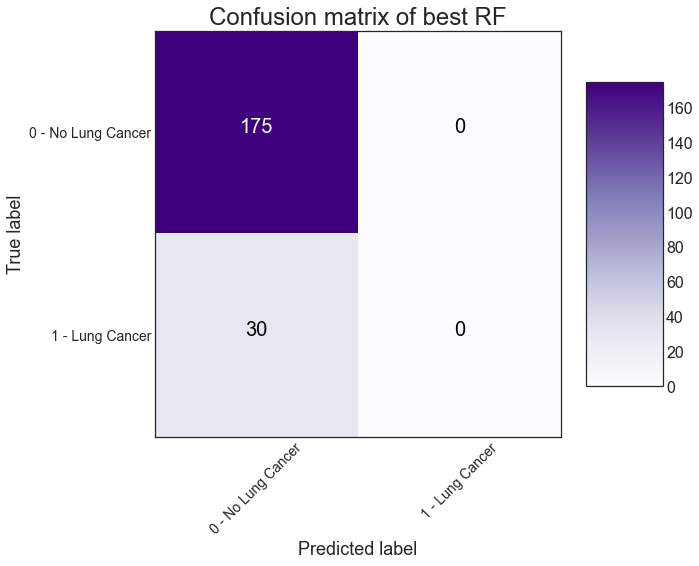

In [33]:
y_pred = rf_best.predict(X_test)
accuracy_score(y_test, y_pred)
print(f'The accuracy of the model is {round(accuracy_score(y_test, y_pred), 3)*100} %')

print(f'Predicted vs. True: {y_pred.sum(), y_test.sum()}')

cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm,
        classes = ['0 - No Lung Cancer', '1 - Lung Cancer'],
        title = 'Confusion matrix of best RF',
        cmap = plt.cm.Purples)

# Definitely worse

### 3. Pruned Random Forest classifier
Imbalance dataset, weighted class.

Looking at the documentation of RandomForestClassifier, we see the attribute *ccp_alpha* (non-negative float, default = 0.0).

This is the complexity parameter used for Minimal Cost-Complexity Pruning. The subtree with the largest cost complexity that is smaller than ccp_alpha will be chosen. By default, no pruning is performed.

Let us try it to see if the situation gets better

In [34]:
rf_pruned = RandomForestClassifier(random_state = 2311, n_jobs = -1,
                        ccp_alpha = 0.001,
                        n_estimators = 500, min_samples_leaf = 4, 
                        min_samples_split = 10, max_leaf_nodes = 35,
                        max_depth = 48, class_weight = "balanced_subsample",
                        bootstrap = True, oob_score = True)

rf_pruned.fit(X_train, y_train)
print('Training score: ', rf_pruned.score(X_train, y_train))
print('Test score: ', rf_pruned.score(X_test, y_test))

C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Training score:  1.0
Test score:  0.8536585365853658


The accuracy of the model is 85.39999999999999 %
Predicted vs. True: (0, 30)


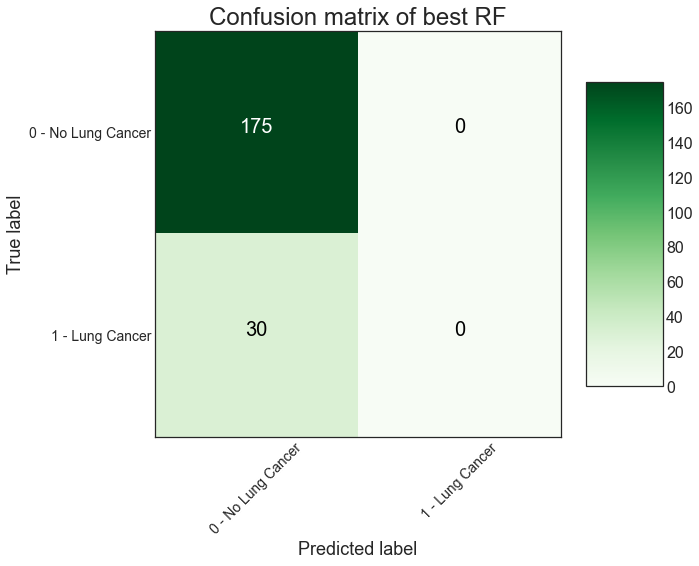

In [35]:
y_pred = rf_pruned.predict(X_test)
accuracy_score(y_test, y_pred)
print(f'The accuracy of the model is {round(accuracy_score(y_test, y_pred), 3)*100} %')

print(f'Predicted vs. True: {y_pred.sum(), y_test.sum()}')

cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm,
        classes = ['0 - No Lung Cancer', '1 - Lung Cancer'],
        title = 'Confusion matrix of Pruned RF',
        cmap = plt.cm.Greens)

# No improvements =(

In [36]:
# Let us try a 3-fold cv for finding the optimal alpha
ccp_alpha = [float(x) for x in np.linspace(start = 0.0001, stop = 0.01, num = 50)]
max_features = ['auto', 'log2']  # Number of features to consider at every split
max_depth = [int(x) for x in np.linspace(2, 50, num = 15)]   # Maximum number of levels in tree
max_depth.append(None)

random_grid = {'ccp_alpha': ccp_alpha,
               'max_features': max_features,
               'max_depth': max_depth}

# First create a base model: 
rf = RandomForestClassifier(n_estimators = 500, min_samples_leaf = 4, 
                        min_samples_split = 10, max_leaf_nodes = 48,
                        class_weight = "balanced_subsample",
                        bootstrap = True, oob_score = True)

# Then, use random grid to select the best model, based on the ROC_AUC score, hence scoring = 'roc_auc'
rf_random = RandomizedSearchCV(
                    estimator = rf,
                    param_distributions = random_grid,
                    n_iter = 2, cv = 3,
                    verbose = 2, random_state = 2311, 
                    scoring = 'roc_auc')


In [37]:
# Finally, fit the data
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 2 candidates, totalling 6 fits


C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[CV] END ccp_alpha=0.0001, max_depth=None, max_features=auto; total time= 1.5min


C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[CV] END ccp_alpha=0.0001, max_depth=None, max_features=auto; total time= 1.4min


C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[CV] END ccp_alpha=0.0001, max_depth=None, max_features=auto; total time= 1.3min


C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[CV] END ccp_alpha=0.0071714285714285725, max_depth=26, max_features=auto; total time= 1.2min


C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[CV] END ccp_alpha=0.0071714285714285725, max_depth=26, max_features=auto; total time= 1.3min


C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[CV] END ccp_alpha=0.0071714285714285725, max_depth=26, max_features=auto; total time= 1.4min


C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


RandomizedSearchCV(cv=3,
                   estimator=RandomForestClassifier(class_weight='balanced_subsample',
                                                    max_leaf_nodes=48,
                                                    min_samples_leaf=4,
                                                    min_samples_split=10,
                                                    n_estimators=500,
                                                    oob_score=True),
                   n_iter=2,
                   param_distributions={'ccp_alpha': [0.0001,
                                                      0.0003020408163265306,
                                                      0.0005040816326530613,
                                                      0.000706122448979592,
                                                      0.0009081632653061226,
                                                      0.0011102040816326532,
                                                      0.0

In [38]:
rf_random.best_params_

# It takes the very first alpha: maybe should change the interval of alphas

{'max_features': 'auto', 'max_depth': None, 'ccp_alpha': 0.0001}

In [40]:
rf_pruned_best = RandomForestClassifier(random_state = 2311, n_jobs = -1,
                        ccp_alpha = 0.0001,
                        n_estimators = 500, min_samples_leaf = 4, 
                        min_samples_split = 10, max_leaf_nodes = 35,
                        max_depth = None, class_weight = "balanced_subsample",
                        bootstrap = True, oob_score = True)

rf_pruned_best.fit(X_train, y_train)
print('Training score: ', rf_pruned_best.score(X_train, y_train))
print('Test score: ', rf_pruned_best.score(X_test, y_test))

C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Training score:  1.0
Test score:  0.8536585365853658


The accuracy of the model is 85.39999999999999 %
Predicted vs. True: (0, 30)


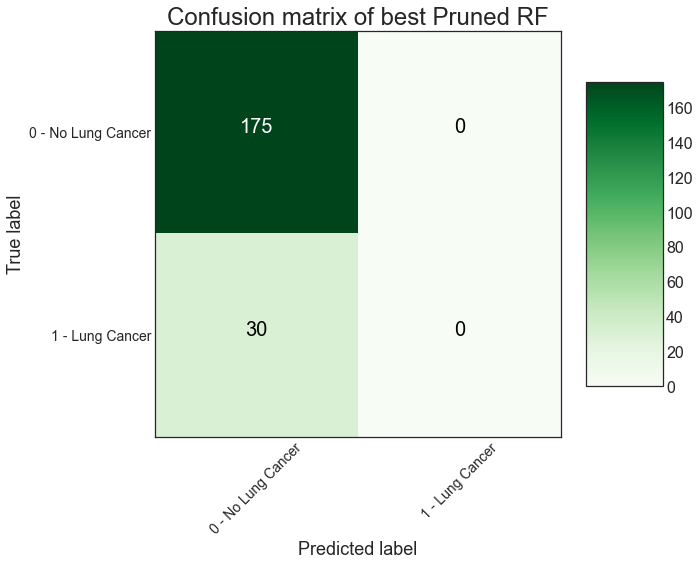

In [41]:
y_pred = rf_pruned_best.predict(X_test)
accuracy_score(y_test, y_pred)
print(f'The accuracy of the model is {round(accuracy_score(y_test, y_pred), 3)*100} %')

print(f'Predicted vs. True: {y_pred.sum(), y_test.sum()}')

cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm,
        classes = ['0 - No Lung Cancer', '1 - Lung Cancer'],
        title = 'Confusion matrix of best Pruned RF',
        cmap = plt.cm.Greens)

# No improvements =(

### 4. Last try
Fit k = 100 tree as in bagging but on balanced dataset

In [45]:
from imblearn.under_sampling import RandomUnderSampler
from sklearn.tree import DecisionTreeClassifier

In [48]:
models = []

for i in range(100):
    # create random undersampling of majority class
    rus = RandomUnderSampler(random_state = i)
    X_res, y_res = rus.fit_resample(X_train, y_train)

    model_i = DecisionTreeClassifier()
    model_i = model_i.fit(X_res, y_res)

    models.append(model_i) 

KeyboardInterrupt: 

In [ ]:
sum_pred = 0
for i in range(len(models)):
    sum_pred += models[i].predict(X_test)

ensemble_prediction = (sum_pred/len(models)) > 0.5

cm = confusion_matrix(y_test, ensemble_prediction)
plot_confusion_matrix(cm,
        classes = ['0 - No Lung Cancer', '1 - Lung Cancer'],
        title = 'Confusion matrix of Bagging',
        cmap = plt.cm.Pinks)

### 5. Features impotances
We have tried different models and the best one is the first one: *rf*. Let us stick with it.

Even if probably does not make any sense to persue with this classification, we want to identify the most relevant features. Thus, our aim now is to remove unnecessary features from the data to reduce noise. In particular, we will perform a 5-fold cross validation to reach this aim. The idea is to get the feature importance values from each of the 5 models built in the 5-fold cross-validation and then take the average of the 5 importance values for each feature in order to select the top N features for the final model.

In [56]:
rf_cl = RandomForestClassifier(random_state = 2311, n_jobs = -1,
                n_estimators = 500, class_weight = 'balanced_subsample',
                bootstrap = True, oob_score = True)

out = cross_validate(rf_cl, X_train, y_train, cv = 5, n_jobs = -1,
                scoring = 'accuracy', return_estimator = True)

In [59]:
feat_impo_all = []
for i, estimator in enumerate(out['estimator']):
    print("First 10 features sorted by their importance for model n. {}:".format(i+1))
    feat_impo = pd.DataFrame(estimator.feature_importances_,
                            index = X_train.columns,
                            columns = ['Importance{}'.format(i+1)]).sort_values('Importance{}'.format(i+1), ascending = False)
    print(feat_impo[:10])
    print('--------------------------------')

    feat_impo_all.append(feat_impo[feat_impo['Importance{}'.format(i+1)] > 0.001])

First 10 features sorted by their importance for model n. 1:
                  Importance1
HIST1H2BE..8344.     0.004344
RPP25L..138716.      0.004166
CCT4..10575.         0.003872
LEXM..163747.        0.003383
HIST1H2BC..8347.     0.002843
RAB18..22931.        0.002771
POP7..10248.         0.002314
CYB5A..1528.         0.002237
POLR3K..51728.       0.002206
DNAJC6..9829.        0.002136
--------------------------------
First 10 features sorted by their importance for model n. 2:
                  Importance2
RPP25L..138716.      0.005802
CCT4..10575.         0.003872
INSL5..10022.        0.003365
RPL36..25873.        0.002856
IFNE..338376.        0.002783
OLR1..4973.          0.002696
FANCB..2187.         0.002634
NIPBL..25836.        0.002401
HIST1H2BC..8347.     0.002386
POLR3K..51728.       0.002262
--------------------------------
First 10 features sorted by their importance for model n. 3:
                  Importance3
LEXM..163747.        0.003764
NIPBL..25836.        0.003155
I

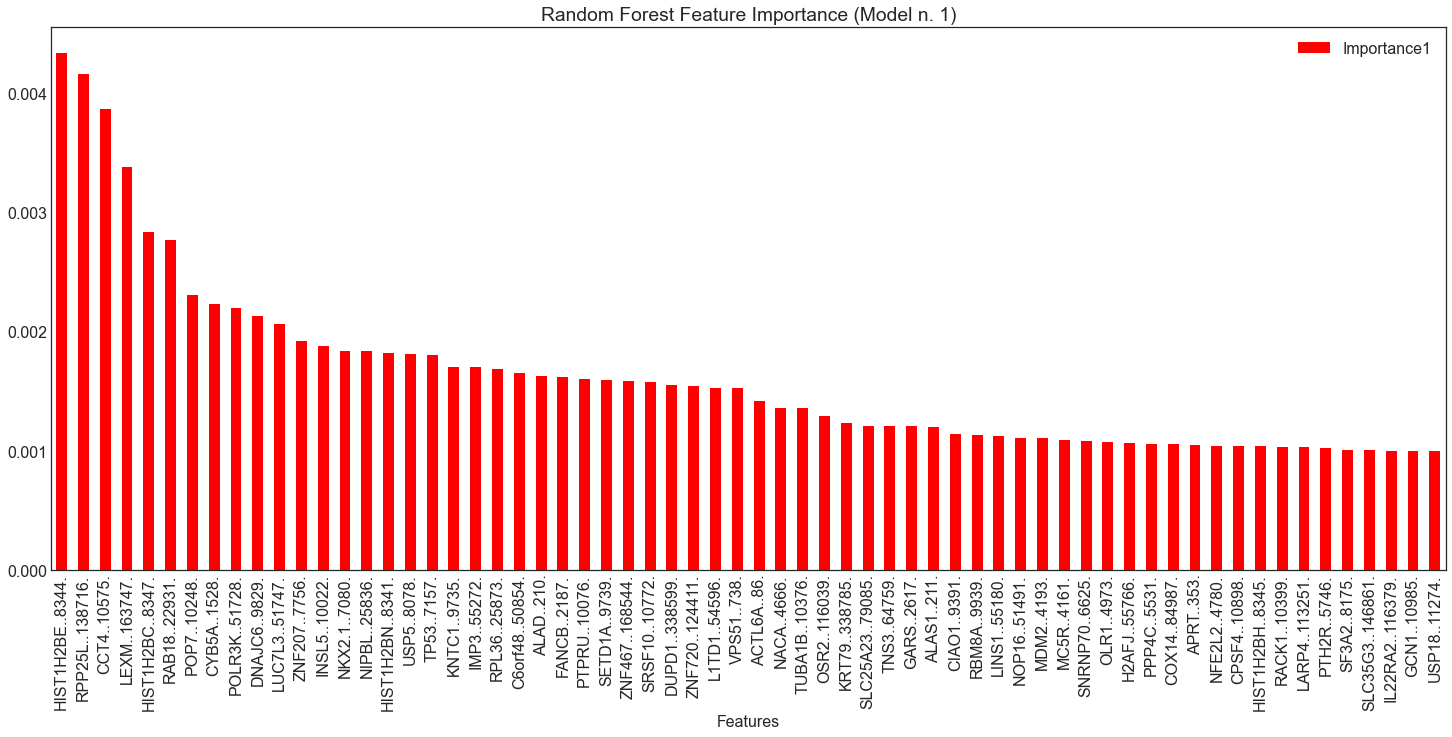

In [60]:
feat_impo_all[0].plot.bar(figsize = (25, 10), color = 'r')
plt.title('Random Forest Feature Importance (Model n. 1)')
plt.xlabel('Features')
plt.show()

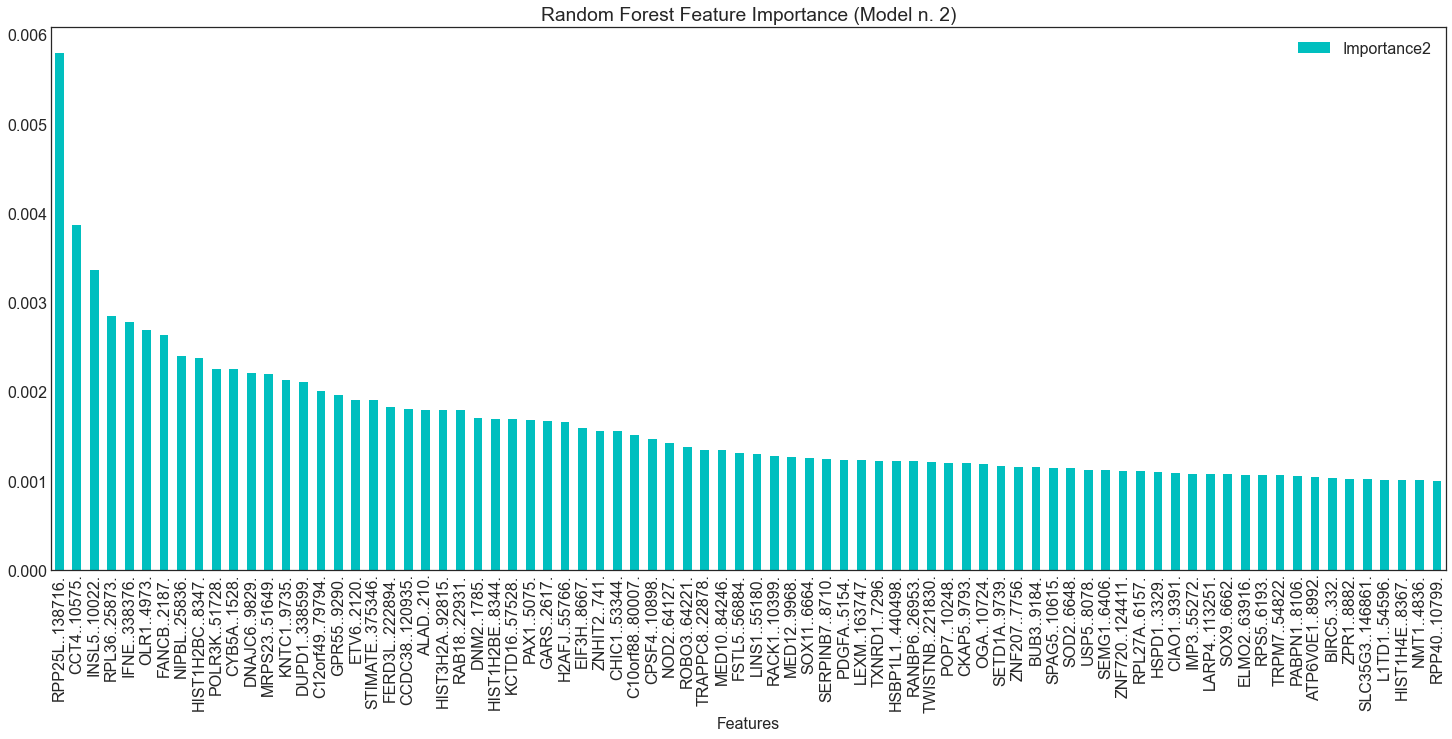

In [62]:
feat_impo_all[1].plot.bar(figsize = (25, 10), color = 'c')
plt.title('Random Forest Feature Importance (Model n. 2)')
plt.xlabel('Features')
plt.show()

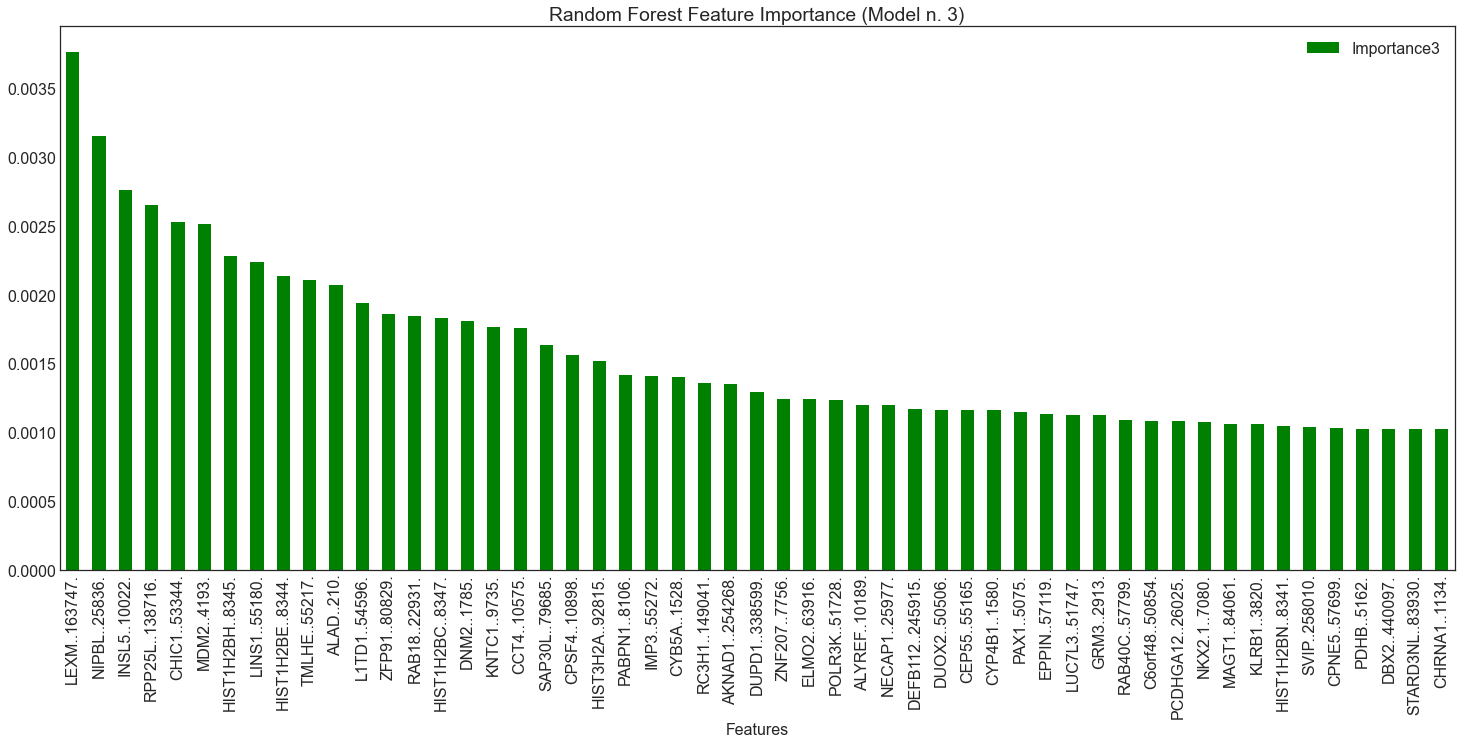

In [63]:
feat_impo_all[2].plot.bar(figsize = (25, 10), color = 'g')
plt.title('Random Forest Feature Importance (Model n. 3)')
plt.xlabel('Features')
plt.show()

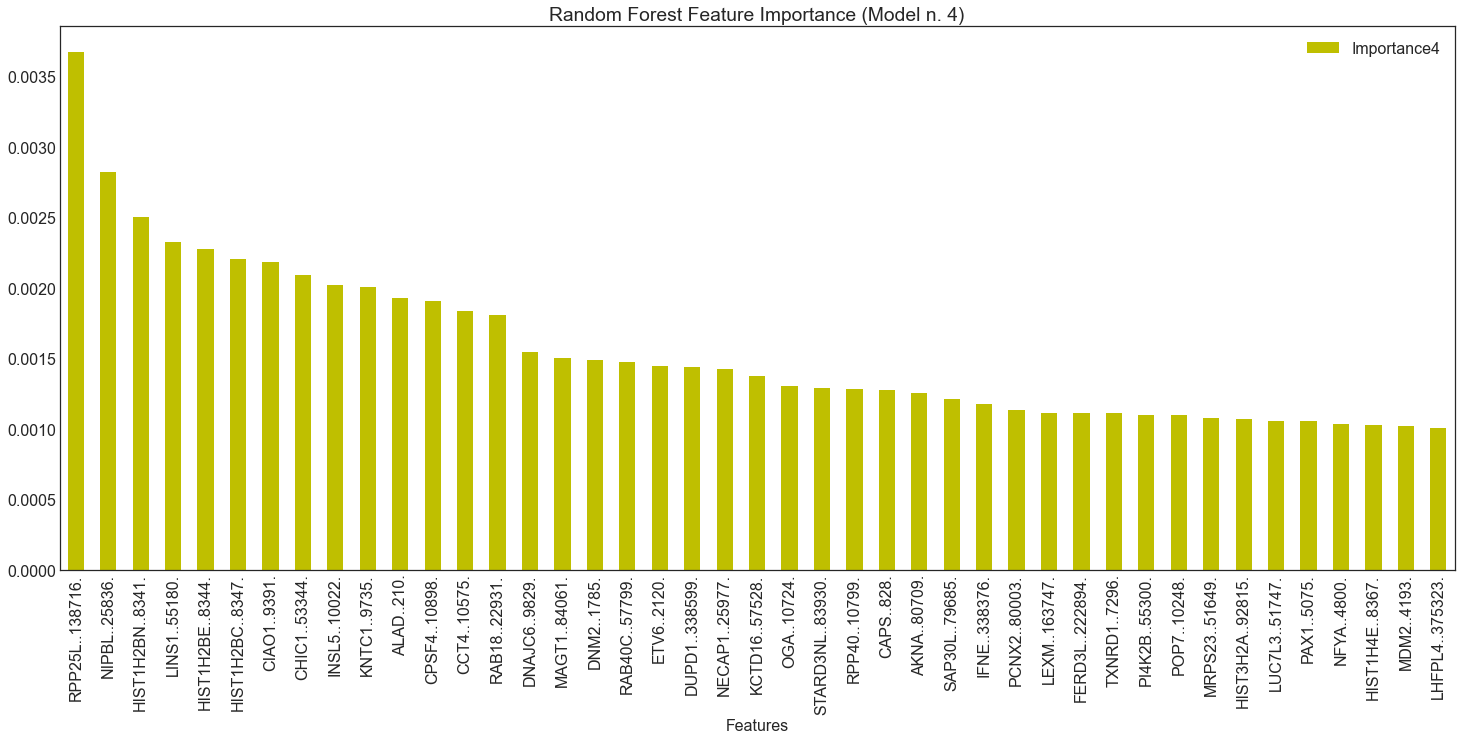

In [64]:
feat_impo_all[3].plot.bar(figsize = (25, 10), color = 'y')
plt.title('Random Forest Feature Importance (Model n. 4)')
plt.xlabel('Features')
plt.show()

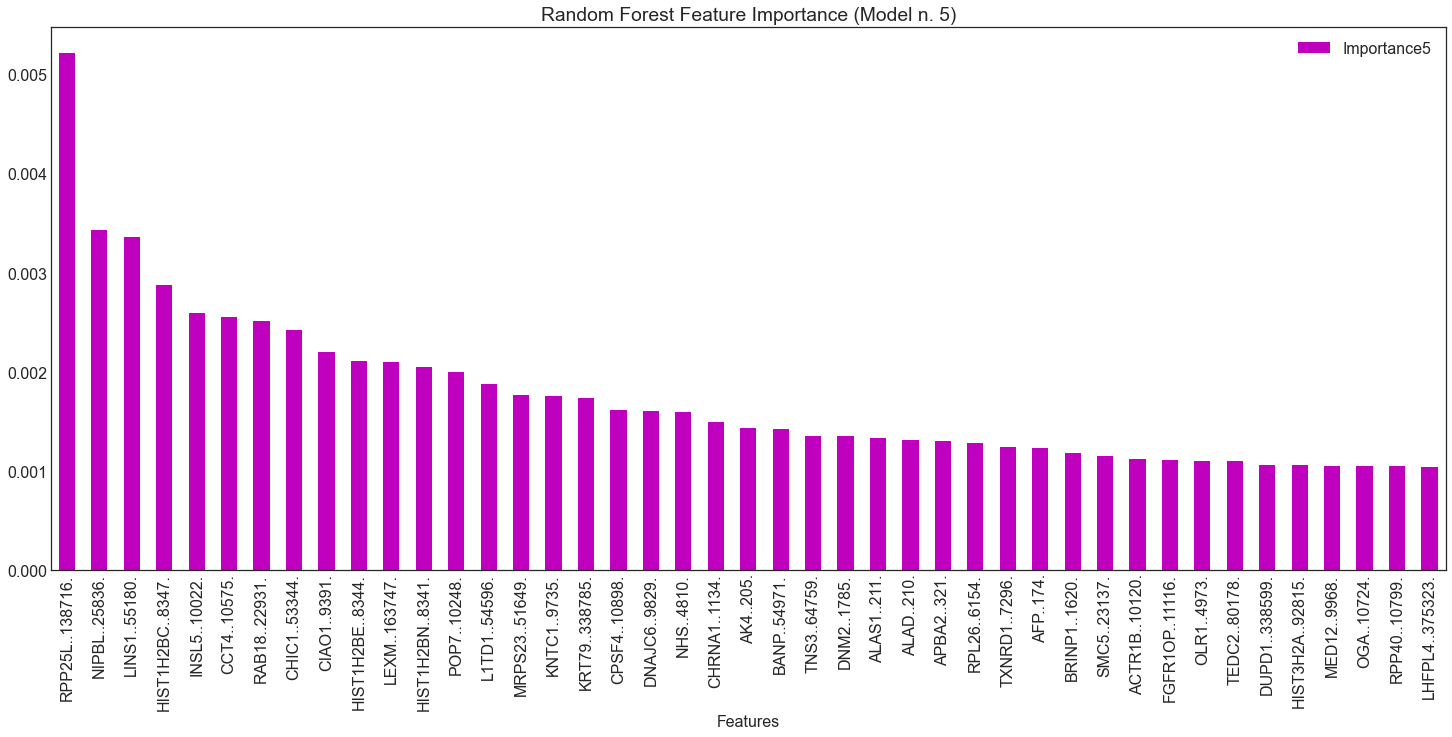

In [65]:
feat_impo_all[4].plot.bar(figsize = (25, 10), color = 'm')
plt.title('Random Forest Feature Importance (Model n. 5)')
plt.xlabel('Features')
plt.show()

In [66]:
df0 = pd.DataFrame(feat_impo_all[0])
df1 = pd.DataFrame(feat_impo_all[1])
df2 = pd.DataFrame(feat_impo_all[2])
df3 = pd.DataFrame(feat_impo_all[3])
df4 = pd.DataFrame(feat_impo_all[4])

In [67]:
most_feat_impo = pd.concat([df0, df1, df2, df3, df4], axis = 1)
most_feat_impo

,Importance1,Importance2,Importance3,Importance4,Importance5
HIST1H2BE..8344.,0.004344,0.001695,0.002137,0.002273,0.002112
RPP25L..138716.,0.004166,0.005802,0.002657,0.003672,0.005225
CCT4..10575.,0.003872,0.003872,0.001761,0.001834,0.002556
LEXM..163747.,0.003383,0.001238,0.003764,0.001116,0.002105
HIST1H2BC..8347.,0.002843,0.002386,0.001831,0.002203,0.002882
...,...,...,...,...,...
BRINP1..1620.,NaN,NaN,NaN,NaN,0.001188
SMC5..23137.,NaN,NaN,NaN,NaN,0.001157
ACTR1B..10120.,NaN,NaN,NaN,NaN,0.001129
FGFR1OP..11116.,NaN,NaN,NaN,NaN,0.001119


In [68]:
most_feat_impo = most_feat_impo.dropna()
most_feat_impo['Importance_mean'] = most_feat_impo.mean(axis = 1)
most_feat_impo

<ipython-input-68-2789dce5513e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  most_feat_impo['Importance_mean'] = most_feat_impo.mean(axis = 1)


,Importance1,Importance2,Importance3,Importance4,Importance5,Importance_mean
HIST1H2BE..8344.,0.004344,0.001695,0.002137,0.002273,0.002112,0.002512
RPP25L..138716.,0.004166,0.005802,0.002657,0.003672,0.005225,0.004304
CCT4..10575.,0.003872,0.003872,0.001761,0.001834,0.002556,0.002779
LEXM..163747.,0.003383,0.001238,0.003764,0.001116,0.002105,0.002321
HIST1H2BC..8347.,0.002843,0.002386,0.001831,0.002203,0.002882,0.002429
RAB18..22931.,0.002771,0.001794,0.001849,0.001811,0.002514,0.002148
INSL5..10022.,0.001885,0.003365,0.002766,0.002025,0.002594,0.002527
NIPBL..25836.,0.001840,0.002401,0.003155,0.002824,0.003435,0.002731
KNTC1..9735.,0.001711,0.002135,0.001769,0.002009,0.001764,0.001878
ALAD..210.,0.001628,0.001796,0.002074,0.001928,0.001312,0.001748


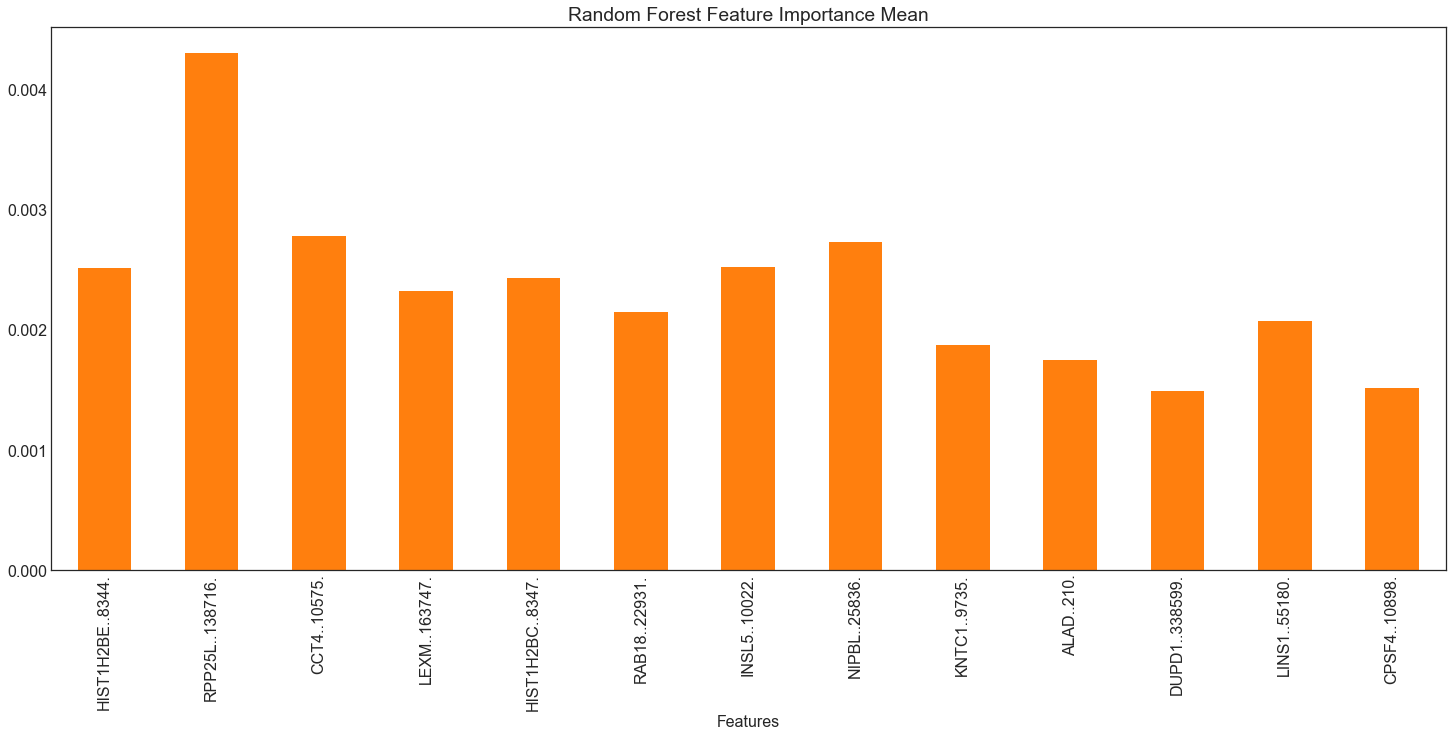

In [69]:
most_feat_impo.Importance_mean.plot.bar(figsize = (25, 10), color = 'tab:orange')
plt.title('Random Forest Feature Importance Mean')
plt.xlabel('Features')
plt.show()

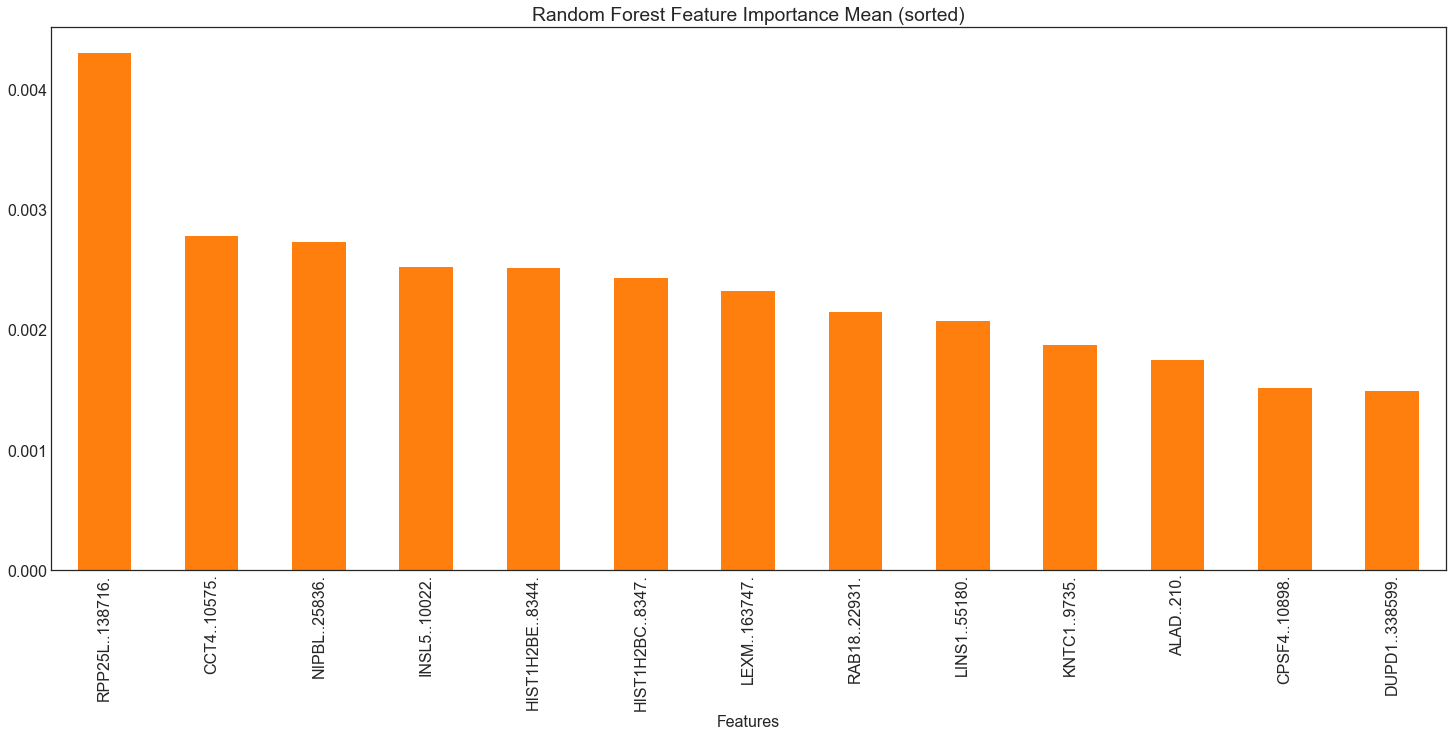

In [70]:
most_feat_impo = most_feat_impo.sort_values('Importance_mean', ascending = False)
most_feat_impo.Importance_mean.plot.bar(figsize = (25, 10), color = 'tab:orange')
plt.title('Random Forest Feature Importance Mean (sorted)')
plt.xlabel('Features')
plt.show()

This is a very poor result but it is in line with what said so far. Our RF classification for Lung Cancer has not provided any good results and indeed, the important features are few and with any significant percentage.

Conclusion: it seems that detecting genes associated to Lung Cancer is a delicate study and we should need a priori biological knowledge in order to proceed with a better classification.

--------------------

--------------------
**Questions**: If I do average the 5 feature importance values for each feature, select the top 200, and then do another 5-fold cross-validation on the model with the top 200 features, is it meaningful? Or will this cause leaking and overfitting since the feature selection was based off of all the data because I averaged the importances from all 5 models from the cross-validation?

A more rigorous way to pursue this question is to apply the **Boruta algorithm**. 

### 5. Boruta algorithm
Boruta repeatedly measures feature importance from a Random Forest (or similar method) and then carries out statistical tests to screen out the features which are irrelevant. The procedure terminatess when a score has been generated for all the features (aka all features are either decisively relevant or decisively irrelevant), or we reach the maximum runs set for the random forest. Here the steps of Boruta algorithm:

1. Create copies of all the original features present in your dataset.
1. Add randomness by shuffling these new feature. This is done to ensure that these new features show no correlation with the response variable.
1. Run random forest classifier on the extended dataset and generate feature importance score based on mean accuracy decrease estimate for all the shadow variables.
1. Compare Z-score of original variable with the maximum Z-score of shadow variables. Real features that have low score compared to the best of shadow features are deemed unimportant.
1. Remove shadow features and repeat the process until an importance score is generated for all the variables.

In [49]:
from boruta import BorutaPy

In [52]:
# # Defining Random Forest Classifier as above
# rf_cl = RandomForestClassifier(random_state = 2311, n_jobs = -1,
#                 n_estimators = 500, class_weight = 'balanced_subsample',
#                 bootstrap = True, oob_score = True)

# rf_cl.fit(X_train, y_train)

C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


RandomForestClassifier(class_weight='balanced_subsample', n_estimators=500,
                       n_jobs=-1, oob_score=True, random_state=2311)

In [ ]:
# # Defining parameters of boruta object for feature selection
# feat_selection = BorutaPy(rf_cl, n_estimators = 'auto', verbose = 1,
#                         max_iter = 3, random_state = 2311)

# # Only 3 iterations since time consuming (dafult is 100)
# # At least 30 minutes

# # Get relevant features
# feat_selection.fit(np.array(X_train), np.array(y_train))

In [ ]:
# # Getting all relevant features
# feat_selection.support_

# # Getting feature ranking
# feat_selection.ranking_

# # Selecting only selected features by using transform() function
# feat_selection.transform(np.array(X_train))

In [ ]:
# # Creating list of varibale name, ranks, and final decision using zip
# feat_rankings = list(zip(X_train.columns,
#                            feat_selection.ranking_,
#                            feat_selection.support_))

# # Printing the list of varibales which got selected
# count = 0
# for i in feat_rankings:
#     if i[2] == True:
#         count += 1
#         print(f'count: {count}  Name: {i[0]} Rank: {i[1]}')

### 7. Comparison of selected features btw first RF model and Pruned RF

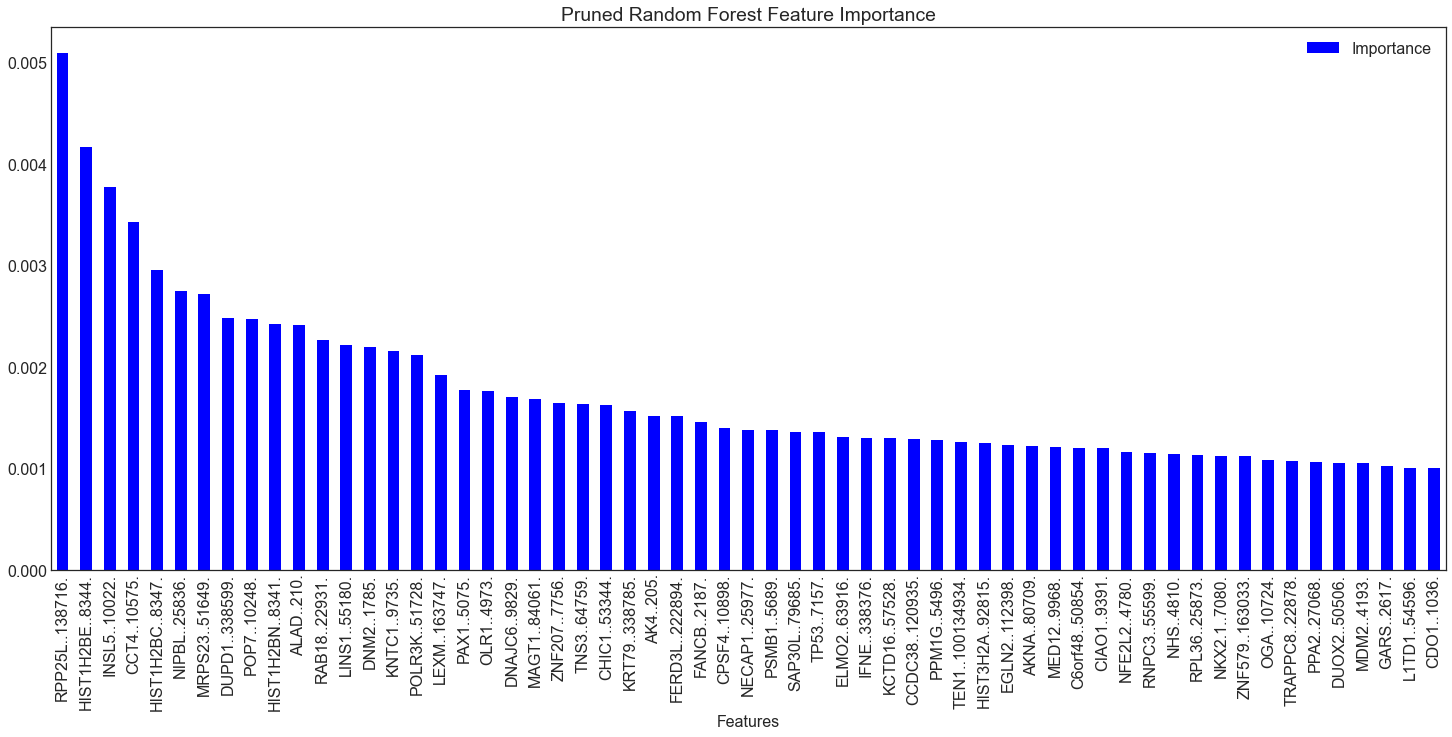

In [72]:
feat_impo_new = pd.DataFrame(rf_pruned.feature_importances_,
                        index = X_train.columns,
                        columns = ['Importance']).sort_values('Importance', ascending = False)
                        
feat_impo_new[feat_impo_new.Importance > 0.0010].plot.bar(figsize = (25, 10), color = 'b')
plt.title('Pruned Random Forest Feature Importance')
plt.xlabel('Features')
plt.show()

In [73]:
select_feat = feat_impo_new.loc[most_feat_impo.index]
select_feat = select_feat.sort_values('Importance', ascending = False)

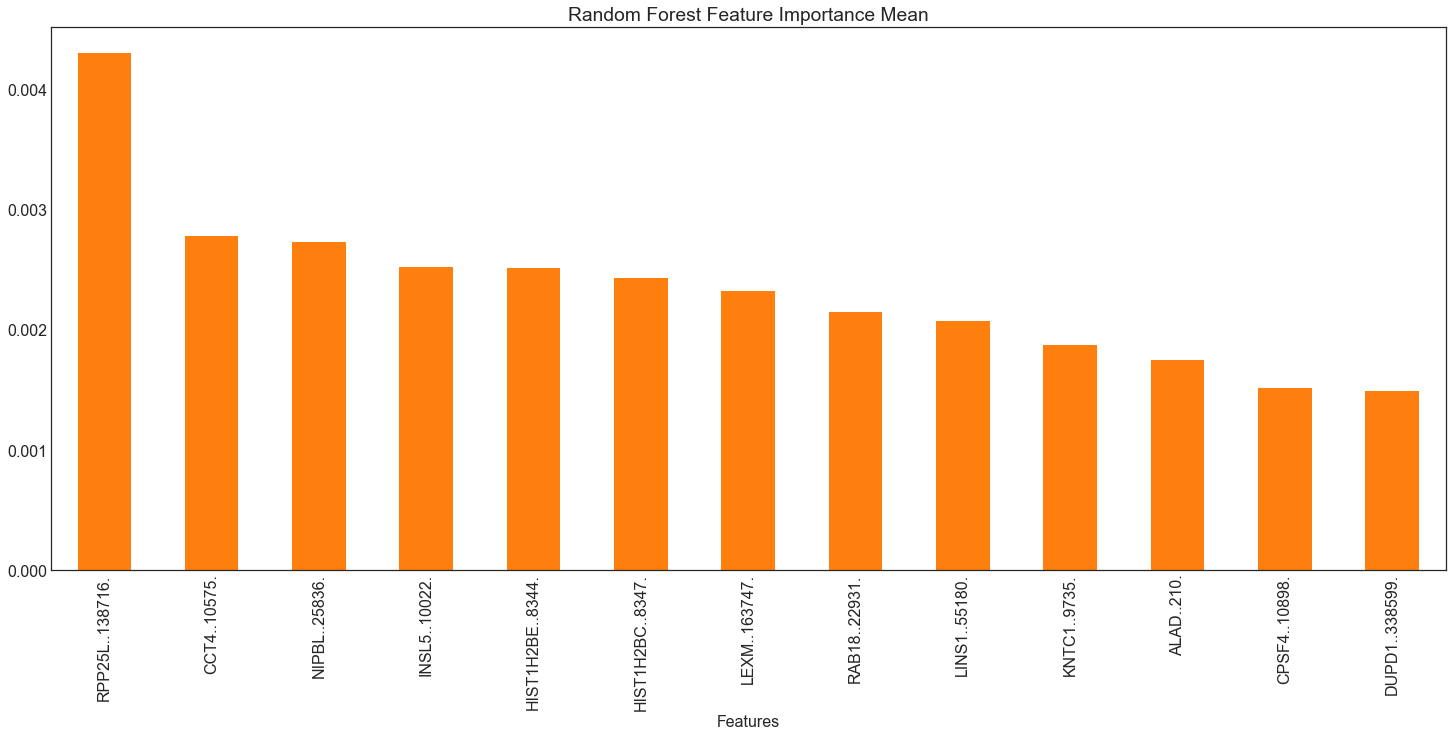

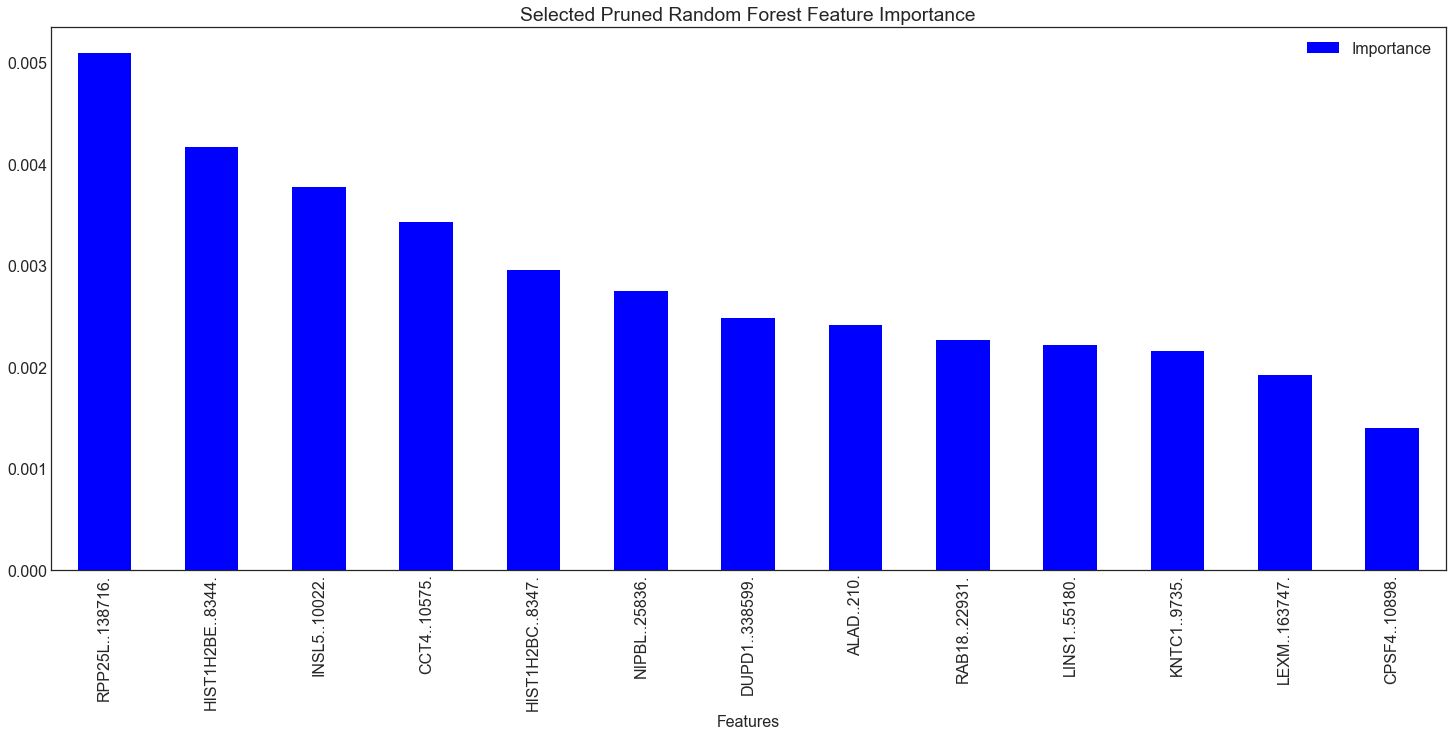

In [74]:
most_feat_impo.Importance_mean.plot.bar(figsize = (25, 10), color = 'tab:orange')
plt.title('Random Forest Feature Importance Mean')
plt.xlabel('Features')
plt.show()


select_feat.plot.bar(figsize = (25, 10), color = 'b')
plt.title('Selected Pruned Random Forest Feature Importance')
plt.xlabel('Features')
plt.show()


# cosa carina: plottarli assieme, con le barre uno di fianco all'altro